# Problem Statement

[An article in the Dallas Observer](https://www.dallasobserver.com/restaurants/dallas-restaurant-inspections-suffer-from-delays-poor-record-keeping-and-overworked-staff-10697588) unearthed a massive problem in the city's ability to follow up on restaurants requiring reinspection due to a low grade upon original inspection.  Dallas states that out of a scale from 1-100, any facility that scores between 70-79 requires reinspection within 30 days, between 60-69 requires reinspection within 10 days, and below 60 requires reinspection ASAP.

The article points out many flaws in the city's ability to reinspect restaurants within its own self-imposed timeframes.  Until the department can hopefully become better-staffed, I am looking to build a classification model that can predict how a restaurant will perform upon reinspection.  This way, if the city is still struggling to reinspect restaurants in a timely manner, they can refer to the model in order to prioritize certain facilities to reinspect.

The target metric for my model is to improve upon the baseline, which would be an accuracy score of greater than __60.38%__.


In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist


%matplotlib inline

# Data Collection

In [212]:
df = pd.read_csv('../data/Restaurant_and_Food_Establishment_Inspections__October_2016_to_Present_.csv')

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,97,103,105,106,107,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [213]:
df.head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
0,FRESHII,Routine,10/31/2018,96,2414,VICTORY PARK,NaN,LN,NaN,2414 VICTORY PARK LN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2018,FY2019,"2414 VICTORY PARK LN\n(32.787625, -96.809294)"
1,MICKLE CHICKEN,Routine,10/30/2019,100,3203,CAMP WISDOM,W,RD,NaN,3203 W CAMP WISDOM RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,"3203 W CAMP WISDOM RD\n(32.662584, -96.873446)"
2,WORLD TRADE CENTER MARKET,Routine,11/03/2016,100,2050,STEMMONS,N,FRWY,NaN,2050 N STEMMONS FRWY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2016,FY2017,"2050 N STEMMONS FRWY\n(32.801934, -96.825878)"
3,DUNKIN DONUTS,Routine,10/30/2019,99,8008,HERB KELLEHER,NaN,WAY,C2174,8008 HERB KELLEHER WAY STE# C2174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,8008 HERB KELLEHER WAY STE# C2174
4,CANVAS HOTEL - 6TH FLOOR,Routine,06/11/2018,100,1325,LAMAR,S,ST,NaN,1325 S LAMAR ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"1325 S LAMAR ST\n(39.69335, -105.067425)"


# Data Cleaning

In [214]:
df.shape # checks shape of data

(44656, 114)

In [215]:
df.isnull().sum().sort_values(ascending = False).head() #check nulls

Violation Detail - 25         44654
Violation Memo - 25           44653
Violation Points - 25         44653
Violation Description - 25    44653
Violation Description - 24    44649
dtype: int64

There are a few restaurants with null values for restaurant name.  Let's investigate this.

In [216]:
df.loc[df['Restaurant Name'].isnull()]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
24064,NaN,Routine,07/28/2017,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24612,NaN,Routine,08/06/2018,91,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
26713,NaN,Routine,02/02/2017,88,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
33050,NaN,Routine,11/27/2017,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
34370,NaN,Routine,06/13/2018,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
39616,NaN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,05/31/2017,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43934,NaN,Routine,01/03/2018,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


Null values are only impacting the same 3 restaurants, so I can look individually.

In [217]:
df.loc[df['Street Number'] == 4243].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
4333,WILLIAMS CHICKEN,Routine,08/14/2019,94,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
10552,WILLIAMS CHICKEN,Routine,02/12/2020,92,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2020,FY2020,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
14015,WILLIAMS CHICKEN,Routine,02/11/2019,97,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"


In [218]:
df.loc[df['Street Number'] == 8686].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
339,DONUT TOWN,Routine,11/23/2018,98,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2018,FY2019,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
32431,DONUT TOWN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
33050,NaN,Routine,11/27/2017,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
39616,NaN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,05/31/2017,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"


In [219]:
df.loc[df['Street Number'] == 6449].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
8299,FRANKIE'S FOOD MART,Routine,12/09/2019,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2019,FY2020,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
17424,FRANKIE'S FOOD MART,Routine,12/04/2018,81,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2018,FY2019,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24064,NaN,Routine,07/28/2017,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
34370,NaN,Routine,06/13/2018,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
43934,NaN,Routine,01/03/2018,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


While the null restaurants seem to line up with an actual restaurant, I could not find evidence that locations were identical or different restaurants during the time of inspection.  Instead of imputing what we assume is the restaurant name, I will impute the name of unkown.

In [220]:
df.dtypes.value_counts()

object     87
float64    25
int64       2
dtype: int64

We have 87 string columns that we want to use CountVectorizer on.  Typing out every single string column would be tedious and wildly ineffective.  Instead, we will run it for all string columns.

In [221]:
dtypes_df = pd.DataFrame(df.dtypes)

object_cols = dtypes_df.loc[dtypes_df[0] == 'object'].index # get string columns

float_cols = dtypes_df.loc[dtypes_df[0] == 'float64'].index # get float cols

In [222]:
df[object_cols] = df[object_cols].fillna(' ') # handles null string values

In [223]:
df['Inspection Score'].describe()

count    44656.000000
mean        90.367991
std          7.060127
min         -5.000000
25%         86.000000
50%         91.000000
75%         96.000000
max        100.000000
Name: Inspection Score, dtype: float64

A score cannot be negative.  Clearly there are some errors here.  The Inspection Score should be 100 minus the amount of violation points they accrue.  While the data dictionary did state that some violations could be fixed during the inspection, which accounts for a difference in scores, -5 makes no sense, and I'm looking to utilize NLP and word association to predict score, so I would rather use a calculated score to evaluate.

In [224]:
df['calculated_score'] = 100 - df[float_cols].sum(axis = 1) #creates a new score column

In [225]:
df.loc[df['Inspection Score'] != df['calculated_score']]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score
20,JERSEY MIKES SUBS,Routine,10/04/2018,89,14060,DALLAS,,PKWY,400,14060 DALLAS PKWY STE 400,...,,,,NaN,,,Oct 2018,FY2019,"14060 DALLAS PKWY STE 400\n(32.938693, -96.821...",100.0
30,CANTINA LAREDO,Routine,10/30/2019,0,6025,ROYAL,,LN,#250,6025 ROYAL LN #250,...,,,,NaN,,,Oct 2019,FY2020,"6025 ROYAL LN #250\n(32.894884, -96.802798)",100.0
83,CIELO CREATIONS,Follow-up,03/27/2019,88,2711,HASKELL,N,AVE,#C3,2711 N HASKELL AVE #C3,...,,,,NaN,,,Mar 2019,FY2019,"2711 N HASKELL AVE #C3\n(32.807044, -96.792783)",100.0
308,PIZZA HUT,Routine,06/12/2019,83,222,CONTINENTAL,,AVE,,222 CONTINENTAL AVE,...,,,,NaN,,,Jun 2019,FY2019,"222 CONTINENTAL AVE\n(32.78378, -96.814079)",100.0
1579,PARKIT MKT,Routine,11/06/2019,92,4724,GREENVILLE,,AVE,#A,4724 GREENVILLE AVE #A,...,,,,NaN,,,Nov 2019,FY2020,"4724 GREENVILLE AVE #A\n(32.84534, -96.769994)",91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42734,A W BROWN FELLOWSHIP CHURCH,Routine,04/18/2018,84,6901,WESTMORELAND,S,RD,,6901 S WESTMORELAND RD,...,,,,NaN,,,Apr 2018,FY2018,"6901 S WESTMORELAND RD\n(32.663499, -96.881698)",100.0
43052,SAMAD CAFE,Routine,04/25/2017,82,2706,MANOR,,WAY,,2706 MANOR WAY,...,,,,NaN,,,Apr 2017,FY2017,"2706 MANOR WAY\n(32.827271, -96.839715)",85.0
43458,KROGER #689 DELI,Routine,10/29/2018,97,17194,PRESTON,,RD,,17194 PRESTON RD,...,,,,NaN,,,Oct 2018,FY2019,"17194 PRESTON RD\n(32.985862, -96.803703)",100.0
43960,DRIP COFFEE COMPANY,Routine,09/23/2018,92,3888,OAK LAWN,,AVE,#106,3888 OAK LAWN AVE #106,...,,,,NaN,,,Sep 2018,FY2018,"3888 OAK LAWN AVE #106\n(32.816303, -96.802317)",91.0


81 restaurants have an inspection score that does not match up with the calculated score.  Since we are ultimately using NLP from the inspection details and memos, we'll utilize the calculated score to make predictions.  This way the notes will directly match up with the score.

In [226]:
df.drop(columns=float_cols, inplace= True)
df.drop(columns='Inspection Score', inplace= True)

Keeping in the float columns would violate colinearity since the calculated score is just 100 minus the sum of the violation float columns.  Also, dropping inspection score because the calculated score is what we're basing everything off of.

Since this project is based on NLP, we will be merging all of the violation detail, description, and memo columns.  Any leftover nulls after that merge likely relate to a restaurant having no violations to note, which is important data.  If there is an address given, we will keep them just in case we see any trends in terms of location.  Lastly, since we are trying to predict a future score, we will need to re-sort the index to be sequential.

In [227]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date']) #converts to datetime

df.loc[df[df.columns[3:]].duplicated()].sort_values(by = "Inspection Date") 

df = df.sort_values(by = 'Inspection Date') # re-sorts dataframe in order of inspection date

df.reset_index(inplace = True) # sets index equal to inspection date (ascending)

df.drop(columns= 'index', inplace = True) # gets rid of the extra column

In [228]:
df['next_inspection_score'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['calculated_score'].shift(-1)

We just used a time series element to create a new column of lagged scores.  While we are not building any time series models, this was important because the problem statement calls for us to utilize the most recent inspection data in order to predict the following inspection score.  This new column will end up being our target column when it comes to modeling.

In [229]:
df['days_since_last_insp'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['Inspection Date'].diff()

We just engineered a new feature.  We will explore if the time between inspections has an impact on score later on.

In [230]:
df['Inspection Type'].value_counts()

Routine      43990
Follow-up      641
Complaint       25
Name: Inspection Type, dtype: int64

Inspections are grouped into routine, follow-up, or complaint.  Follow-up should reflect inspections that occur within 30 days if score results in the 70s, 10 days in the 60s, and ASAP if below 60.

In [231]:
df['inspection_count'] = df.groupby(['Restaurant Name', 'Street Address','Inspection Year']).cumcount()+1


We just engineered a new feature that lets us know the number of inspections a restaurant had in a fiscal year and then we add that as a column to let us know if the inspection was the first, second, third, and so-on.

In [232]:
df['inspection_count'].value_counts()

1     26576
2     16042
3      1703
4       248
5        61
6        16
7         6
8         2
10        1
9         1
Name: inspection_count, dtype: int64

A restaurant is required to have 2 inspections in a year (every six months).  If there are more than two, it implies that one of the inspections was likely a a follow-up.  According to our data, there were 641 follow-ups, but if there were 1703 instances of a third visit, something is likely not matching up.

In [233]:
df.loc[df['inspection_count'] == 9] # exploring a restaurant that had a significant number of yearly inspections

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
25126,MAMA'S DAUGHTER'S DINER,Routine,2018-07-20,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jul 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",71.0,81.0,114 days,9


In [234]:
df.loc[(df['Restaurant Name'] == "MAMA'S DAUGHTER'S DINER") & (df['Street Name'] == 'ROYAL')]

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
3754,MAMA'S DAUGHTER'S DINER,Routine,2017-01-10,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",95.0,89.0,NaT,1
10415,MAMA'S DAUGHTER'S DINER,Routine,2017-06-30,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jun 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",89.0,67.0,171 days,2
16941,MAMA'S DAUGHTER'S DINER,Routine,2017-12-22,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Dec 2017,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",67.0,75.0,175 days,1
17696,MAMA'S DAUGHTER'S DINER,Routine,2018-01-16,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",75.0,69.0,25 days,2
18059,MAMA'S DAUGHTER'S DINER,Routine,2018-01-24,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",69.0,73.0,8 days,3
18597,MAMA'S DAUGHTER'S DINER,Routine,2018-02-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Feb 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",73.0,63.0,14 days,4
19716,MAMA'S DAUGHTER'S DINER,Routine,2018-03-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",63.0,57.0,28 days,5
20114,MAMA'S DAUGHTER'S DINER,Routine,2018-03-17,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",57.0,63.0,10 days,6
20124,MAMA'S DAUGHTER'S DINER,Routine,2018-03-18,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",63.0,81.0,1 days,7
20724,MAMA'S DAUGHTER'S DINER,Routine,2018-03-28,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",81.0,71.0,10 days,8


None of these visits are classified as follow-ups, even though it is clear that there are follow-ups based on inspection count and inspection scores.  The goal is predict the next visit, and while it would be great to have the data of follow-up/routine as a dummy column, we can't trust that the results are accurate and follow a true pattern.  We will need to drop this column.

In [235]:
df.drop(columns= 'Inspection Type', inplace = True)

In [236]:
df.isnull().sum().sort_values().tail(1)

days_since_last_insp    8483
dtype: int64

Even though we want to prevent data loss, the act of trying to predict the next inspection score makes us have to lag our data.  As we saw previously, I did a lag of one, so I have to drop every restaurant's first score.

In [237]:
df.dropna(inplace = True)

df.reset_index(inplace= True)

df.drop(columns = 'index', inplace = True)

In [238]:
letter_grades = []

for i in df['next_inspection_score']: # converts scores into a letter grade, which is our classification target
    if i < 60:
        letter_grades.append('F')
    if i >= 60 and i < 70:
        letter_grades.append('D')
    if i >= 70 and i < 80:
        letter_grades.append('C')
    if i >= 80 and i < 90:
        letter_grades.append('B')
    if i >= 90:
        letter_grades.append('A')

# adds all new scores to a list

In [239]:
df['next_inspection_grade'] = letter_grades # changes next inspection score to the new list

In [240]:
df['days_since_last_insp'] = df['days_since_last_insp'].astype(int)/24/60/60/1000000000

For modeling purposes, we wanted to convert my datetime column into an int column, so we can use it as a feature.  Since we are treating this as a classification problem, we are not applying any time series models, meaning that unless we convert date to an integer or float, we would have to drop the date as a feature.

In [241]:
orig = df.copy()

# EDA

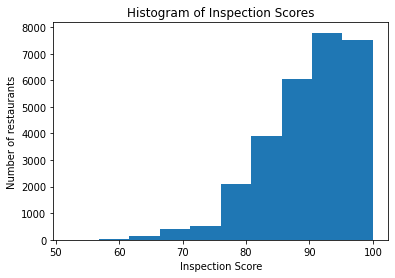

In [242]:
plt.hist(df['calculated_score'], bins = 10)
plt.title('Histogram of Inspection Scores')
plt.xlabel('Inspection Score')
plt.ylabel('Number of restaurants');

In [243]:
len(df.loc[df['calculated_score'] >= 80]) / len(df)

0.9436495939817907

We definitely see a left-skew with our data.  This comes as no surprise since the maximum score a restaurant can receive is 100, and 94% of restaurants receive an A or B, meaning that they do not require another visit until 6 months later.

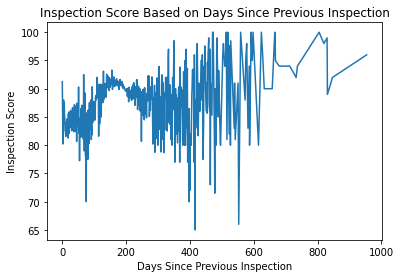

In [244]:
plt.plot(df.groupby(['days_since_last_insp'])['calculated_score'].mean())
plt.title('Inspection Score Based on Days Since Previous Inspection')
plt.xlabel('Days Since Previous Inspection')
plt.ylabel('Inspection Score');

It's hard to decipher a pattern.  In general, it looks like there's an initial trend of score increasing based on the amount of days since the last inspection until a little before 200 days, but there appears to be little pattern afterward.  This makes a lot of sense because places that score above 80 on an inspection do not typically get reinspected until about 180 days (6 months) later.

In [245]:
df.loc[df['days_since_last_insp'] > 800]

,Restaurant Name,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,Violation Description - 1,...,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade
23142,SHERATON DALLAS-BANQUET HALL,2019-01-28,443,OLIVE,N,ST,,443 N OLIVE ST,75201,*43 Clean vent syst:Intake/exhaust air ducts,...,,,Jan 2019,FY2019,"443 N OLIVE ST\n(32.785048, -96.795402)",99.0,92.0,830.0,1,A
26047,SANCHEZ'S PANADERIA Y TAQUERIA,2019-06-10,6131,LAKE JUNE,,PL,,6131 LAKE JUNE PL,75217,*28 Date marking commercially prepared RTE/ TC...,...,,,Jun 2019,FY2019,"6131 LAKE JUNE PL\n(32.734315, -96.715701)",92.0,80.0,847.0,1,B
27512,AFC SUSHI @TOM THUMB #2642,2019-08-28,5809,LOVERS,E,LN,,5809 E LOVERS LN,75206,,...,,,Aug 2019,FY2019,"5809 E LOVERS LN\n(32.851099, -96.766828)",100.0,82.0,805.0,1,B
27651,POPEYES,2019-09-05,3308,DAVIS,W,ST,,3308 W DAVIS ST,75211,*21 Person in charge. The person in charge sha...,...,,,Sep 2019,FY2019,"3308 W DAVIS ST\n(32.749482, -96.874487)",96.0,97.0,954.0,1,A
27721,TAQUERIA CHIMALHUACAH,2019-09-09,13350,AUDELIA,,RD,#100,13350 AUDELIA RD #100,75243,*45 Premises shall be maintained in good repair,...,,,Sep 2019,FY2019,"13350 AUDELIA RD #100\n(32.931073, -96.717957)",89.0,84.0,831.0,1,B
27862,THE CRAB STATION,2019-09-16,2813,COMMERCE,,ST,,2813 COMMERCE ST,75226,*38 Thawing. under running water criteria,...,,,Sep 2019,FY2019,"2813 COMMERCE ST\n(32.783315, -96.782596)",98.0,87.0,820.0,1,B


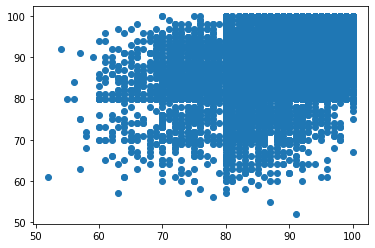

In [246]:
plt.scatter(df['calculated_score'], df['next_inspection_score']);

While this graph doesn't quite visualize a linear relationship, we see what appears to be quadrants forming.  If anything, this visualizes how most restaurants continue to score above 80 because there is next to no white space between the blue dots.

In [247]:
df.drop(columns= 'Street Number', inplace = True)

In [248]:
df.corr().sort_values(by= 'next_inspection_score', ascending= False)

,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
next_inspection_score,0.554437,1.000000,0.105646,-0.088987
calculated_score,1.000000,0.554437,0.078654,-0.079388
days_since_last_insp,0.078654,0.105646,1.000000,-0.376266
inspection_count,-0.079388,-0.088987,-0.376266,1.000000


Looking at our data as a whole, we do see that the greatest feature correlation for predicting the future inspection score is the previous score, with a .5544 positive correlation.  Days since last inspection has a weaker positive correlation at .1056.  Inspection count has a negative correlation of .089, meaning that as inspection count increases, score is likely to decrease.

In [249]:
corr_df = pd.DataFrame(df.groupby(df['next_inspection_grade']).corr().sort_values(by= 'next_inspection_score', ascending= False)[5:]['next_inspection_score'])


corr_df.rename(columns = {'next_inspection_score' : 'Correlation with Next Inpection Score'}, 
               inplace = True)

corr_df.rename_axis(index = {'next_inspection_grade': 'Features by Category'},
                   inplace = True)

corr_df['Features by Category'] = corr_df.index

corr_df.index = corr_df['Features by Category']

corr_df.drop(columns= 'Features by Category', inplace=True)

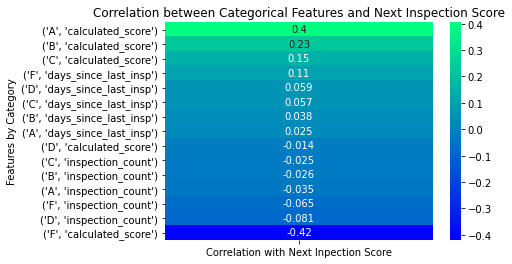

In [250]:
sns.heatmap(corr_df, cmap = 'winter', annot = True)
plt.title('Correlation between Categorical Features and Next Inspection Score');


This is an expansion of the correlation chart above, which showcases correlation between features separates by letter grade vs the next inspection score.  With A, B, & C, we see that the greatest positive correlation for the next inpection score is the previous inspection score, which is not a surprise, since that is the strongest correlation on a cummulative level as well.  

We see that days since last inspection has a stronger positive correlation with future scores among restaurants that scored poorly the first time.  This makes sense because if a restaurant has a low score, they are more likely to improve their score if given some time- especially if some violations require repairs or extensive cleaning to overcome.

The last note here is that a score of D or F has a negative correlation with the future score while A, B, and C have positive correlations.

In [251]:
df['calculated_score'].groupby(df['inspection_count']).mean()

inspection_count
1     90.151705
2     90.433203
3     87.414116
4     83.310811
5     82.288136
6     82.466667
7     78.833333
8     83.000000
9     71.000000
10    81.000000
Name: calculated_score, dtype: float64

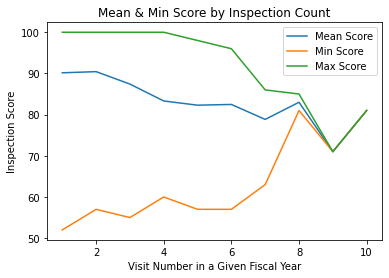

In [252]:
plt.plot(df['calculated_score'].groupby(df['inspection_count']).mean())
plt.plot(df['calculated_score'].groupby(df['inspection_count']).min())
plt.plot(df['calculated_score'].groupby(df['inspection_count']).max())
plt.legend(('Mean Score', 'Min Score', 'Max Score'))
plt.title('Mean & Min Score by Inspection Count')
plt.xlabel('Visit Number in a Given Fiscal Year')
plt.ylabel('Inspection Score');

This further investigates the relationship between number of visits and future inspection score.  We saw a negataive correlation in the coefficients, so we decided to explore it a little more in-depth here.  A few things we see:
* The best-scoring restaurants tend to only be inspected twice a year, which is why the maximum and mean scores are highest when there are a low number of visits.  Even though the min is at its lowest, our unbalanced class of A & B inspection scores are going to be more prevalent during the first two inpections as well.
* There are no perfect inspection scores for restaurants on a 5th inspection or greater.
* The 8th and 10th inspections are the only count that has 100% of restaurants score above a B.
* There are few restaurants that require more than 6 inspections, which is why we see the max, min, and mean get a lot closer together.

# Model Preparation

### Count Vectorizer

In [253]:
string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index 

str_to_drop = string_cols[1:6]

df.drop(columns = str_to_drop, inplace = True)

df.drop(columns = df.columns[2:3], inplace = True)

df.drop(columns = 'next_inspection_grade', inplace = True)

string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index

In [254]:
df['alltext'] = df[string_cols[:-1]].apply(
    lambda x: ' '.join(x.dropna().astype(str)), axis = 1)

# code is from Ed Chum on https://stackoverflow.com/questions/33098383/merge-multiple-column-values-into-one-column-in-python-pandas


In order to prepare for CountVectorizer, we need to merge all string columns into one column.  Let's drop the individual columns.

In [255]:
df.drop(columns = string_cols, inplace=True)

In [256]:
list_of_strings = df['alltext']

In [257]:
cvec = CountVectorizer(lowercase = True, # turn everything to lower case
                       ngram_range = (1, 3),
                      stop_words= 'english',
                       max_features= 2100) # 

# data run through cvec must be transformed
X_text = cvec.fit_transform(list_of_strings)

Originally, I ran a grid search to find the best parameters for CountVectorizer.  If I didn't limit my max features, I would end up with almost 800,000 features, and modeling with that amount was not feasible on my machine, given the time constraint and budget of the project.

In [258]:
X_text_df = pd.DataFrame(X_text.toarray(),
                      columns = cvec.get_feature_names())


In [259]:
X_text_df.head()

,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 111,õ228 111 title,õ228 206,õ228 206 title,õ228 71,õ228 71 title,õ228 73,õ228 73 title,õ228 78,õ228 78 title
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


In [260]:
df.drop(columns = ['Inspection Date', 'alltext'], inplace=True)

In [261]:
X_text_df[df.columns] = df
# .merge and .join were not feasible on this machine with the number of columns, so I had to combine this way

In [262]:
X_text_df['next_inspection_grade'] = letter_grades

## Train, Test, Split

In [263]:
# we are utilizing the df that has our values already run through Cvec
X = X_text_df.drop(columns = ['next_inspection_score', 'next_inspection_grade']) #predictive variable
y = X_text_df['next_inspection_grade']

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 63, stratify = y)

# Modeling

Note: For reader efficiency, gridsearches are set up with the highest-performing hyperparameters used.

## Baseline

In [265]:
y.value_counts()/len(df)

A    0.603825
B    0.349316
C    0.038668
D    0.007839
F    0.000352
Name: next_inspection_grade, dtype: float64

Baseline model would perform at 60.3% accuracy, which would be if my model predicted A every time.

In [266]:
pipe = Pipeline([ #instantiate transformers and model 
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(random_state = 63))
])

# set hyperparameters

pipe_params = {'tfidf__use_idf'  : [True], #
              'lr__solver': ['lbfgs'],
              'lr__penalty': ['l2']}

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 3, # cross validation of 3
                 scoring = 'accuracy')

logreg1 = gs.fit(X_train,y_train)

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

In [267]:
logreg_train = round(logreg1.score(X_train, y_train), 4)

logreg_test = round(logreg1.score(X_test, y_test), 4)

logreg_cv = round(cross_val_score(logreg1.best_estimator_, X, y).mean(), 4)

print(f'Training accuracy score for our Logistic Regression model is: {logreg_train}.')
print(f'Testing accuracy score for our Logistic Regression model is: {logreg_test}.')
print(f'Cross-validation score for our Logistic Regression model is: {logreg_cv}.')


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

Training accuracy score for our Logistic Regression model is: 0.6965.
Testing accuracy score for our Logistic Regression model is: 0.69.
Cross-validation score for our Logistic Regression model is: 0.6853.


In [268]:
logreg1.best_params_

{'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__use_idf': True}

Our best Logistic Regression model involved a ridge penalty, the "lbfgs" solver, and use of TFIDF.  This model was very slightly overfit since it had a .6965 training score, but a .69 testing score.  Our lower cross-validation score compared to test score shows that our model might not perform as well against unseen data as it did against our test data, but it is still relatively close.  This is an improvement from our baseline model of .6038, but we can still try to achieve better accuracy.

I would like to try a Naive Bayes model on this data to see if we can improve accuracy.  Due to the extra computing time for TFIDF on an already large dataset, we will forego TFIDF and opt for a Multinomial Naive Bayes model.

# MNB

In [269]:
pipe = Pipeline([ # instantiate
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

# set hyperparameters

pipe_params = {
    'tfidf__use_idf'  : [False],
    'mnb__fit_prior' : [False],          
    'mnb__alpha': [2] #tested out other alpha values and got it narrowed to this
              }

gsnb = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy'
                   )

mnb_fit = gsnb.fit(X_train, y_train)

In [270]:
mnb_fit.best_params_

{'mnb__alpha': 2, 'mnb__fit_prior': False, 'tfidf__use_idf': False}

In [271]:
mnb_train = round(mnb_fit.score(X_train, y_train), 4)

mnb_test = round(mnb_fit.score(X_test, y_test), 4)

mnb_cv = round(cross_val_score(mnb_fit.best_estimator_, X, y).mean(), 4)

print(f'Training accuracy score for our Multinomial Naive Bayes model is: {mnb_train}.')
print(f'Testing accuracy score for our Multinomial Naive Bayes model is: {mnb_test}.')
print(f'Cross-validation score for our Multinomial Naive Bayes model is: {mnb_cv}.')


Training accuracy score for our Multinomial Naive Bayes model is: 0.6781.
Testing accuracy score for our Multinomial Naive Bayes model is: 0.6727.
Cross-validation score for our Multinomial Naive Bayes model is: 0.6729.


Our best Multinomial Naive Bayes model involved an alpha of 2, no prior class probabilities, and no use of TFIDF.  This model was very slightly overfit since it had a .6781 training score, but a .6727 testing score.  Our higher cross-validation score compared to test score shows that our model might perform better  against unseen data than it did against our test data, but the differencd is miniscule.  This is an improvement from our baseline model of .6038, but we can still try to achieve better accuracy.

Since I have a lot of features in the model, I want to try utilizing PCA on my logisitic regression.  This will hopefully create eigenvalues that approriately capture the best parts of each feature.  If successful, this will be a purely predictive model.

# PCA With Logistic Regression

In [272]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [273]:
# code from Austin Ricardson at https://stats.stackexchange.com/questions/144439/applying-pca-to-test-data-for-classification-purposes
# fits PCA, transforms data and fits the decision tree classifier
# on the transformed data
pipe = Pipeline([('pca', PCA()),
                 ('tfidf', TfidfTransformer()),
                 ('lr', LogisticRegression(random_state = 63))])

pipe_params = {
    'tfidf__use_idf'  : [True], #toggle between use of TFIDF
    'lr__penalty': ['none']
}

gslrpca = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 3,
                 scoring = 'accuracy'
                   )



pca_lr_model = gslrpca.fit(X_train_sc, y_train)



/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

In [274]:
pca_lr_train = round(pca_lr_model.score(X_train_sc, y_train), 4)

pca_lr_test = round(pca_lr_model.score(X_test_sc, y_test), 4)

pca_lr_cv = round(cross_val_score(pca_lr_model.best_estimator_, ss.fit_transform(X), y).mean(), 4)

print(f'Training accuracy score for our Logistic Regression model with PCA is: {pca_lr_train}.')
print(f'Testing accuracy score for our Logistic Regression model with PCA is: {pca_lr_test}.')
print(f'Cross-validation score for our Logistic Regression model with PCA is: {pca_lr_cv}.')


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

Training accuracy score for our Logistic Regression model with PCA is: 0.708.
Testing accuracy score for our Logistic Regression model with PCA is: 0.69.
Cross-validation score for our Logistic Regression model with PCA is: 0.6066.


We did not tune any hyperparameters on our Logistic Regression model with PCA, other than utilize TFIDF.  This model was very slightly overfit since it had a .708 training score, but a .69 testing score.  Our lower cross-validation score compared to test score shows that our model might not perform as well against unseen data as it did against our test data.  This is an improvement from our baseline model of .6038, but we can still try to achieve better accuracy, especially since our cross-validation score is extremely close to the baseline accuracy.

I would like to PCA again, but this time with a Decision Tree model on this data to see if we can improve accuracy.  

# PCA With Decision Tree

In [275]:
# code from Austin Ricardson at https://stats.stackexchange.com/questions/144439/applying-pca-to-test-data-for-classification-purposes
# fits PCA, transforms data and fits the decision tree classifier
# on the transformed data
pipe = Pipeline([('pca', PCA()),
                 ('dt', DecisionTreeClassifier(random_state=63))])

pipe_params = {
}

gsdtpca = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 3,
                 scoring = 'accuracy'
                   )



pca_dt_model = gsdtpca.fit(X_train_sc, y_train)


In [276]:
pca_dt_train = round(pca_dt_model.score(X_train_sc, y_train), 4)

pca_dt_test = round(pca_dt_model.score(X_test_sc, y_test), 4)

pca_dt_cv = round(cross_val_score(pca_dt_model.best_estimator_, ss.fit_transform(X), y).mean(), 4)

print(f'Training accuracy score for our Decision Tree model with PCA is: {pca_dt_train}.')
print(f'Testing accuracy score for our Decision Tree model with PCA is: {pca_dt_test}.')
print(f'Cross-validation score for our Decision Tree model with PCA is: {pca_dt_cv}.')


Training accuracy score for our Decision Tree model with PCA is: 0.9991.
Testing accuracy score for our Decision Tree model with PCA is: 0.5717.
Cross-validation score for our Decision Tree model with PCA is: 0.5487.


We did not tune any hyperparameters on our Decision Tree model with PCA.  This was due to the machine's ability to run this model in a timely manner.  This model was very extremely overfit since it had an almost perfect .9991 training score, but a .5717 testing score, which is lower than our baseline.  Our lower cross-validation score compared to test score shows that our model might not perform as well against unseen data as it did against our test data.  This is not an improvement from our baseline model of .6038.

Since we are having trouble exceeding the performance of our Logistic Regression model, I will try to build a Neural Network.

# Neural Network

Neural Networks cannot recognize string characters as a target, so we need to convert our target back to numerical values.

In [277]:
y.replace({
    'A' : 4,
    'B' : 3,
    'C' : 2,
    'D' : 1,
    'F' : 0
}, inplace=True)

I tried this as both individual dummy columns for score and one categorial column.  The model worked better as a singular categorical column, which is what the code above accomplishes.

In [278]:
y = to_categorical(y)

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63, stratify = y)
# have to redo train test split with new target column

In [280]:
model = Sequential()
model.add(Dense(1024, 
                input_shape=(2103,),
                activation='relu'))
model.add(Dense(512,
                activation='relu'))
model.add(Dense(5, activation='softmax'))

In [281]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [282]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=700)

Epoch 1/10
31/31 [==============================] - 7s 230ms/step - loss: 2.5678 - accuracy: 0.6097 - val_loss: 0.7934 - val_accuracy: 0.6789
Epoch 2/10
31/31 [==============================] - 6s 200ms/step - loss: 0.7469 - accuracy: 0.6758 - val_loss: 0.7877 - val_accuracy: 0.6438
Epoch 3/10
31/31 [==============================] - 5s 174ms/step - loss: 0.6972 - accuracy: 0.6957 - val_loss: 0.7126 - val_accuracy: 0.6924
Epoch 4/10
31/31 [==============================] - 6s 188ms/step - loss: 0.6775 - accuracy: 0.7065 - val_loss: 0.7084 - val_accuracy: 0.6902
Epoch 5/10
31/31 [==============================] - 5s 169ms/step - loss: 0.6748 - accuracy: 0.7026 - val_loss: 0.7162 - val_accuracy: 0.6692
Epoch 6/10
31/31 [==============================] - 7s 231ms/step - loss: 0.6776 - accuracy: 0.7017 - val_loss: 0.8101 - val_accuracy: 0.6264
Epoch 7/10
31/31 [==============================] - 6s 188ms/step - loss: 0.6705 - accuracy: 0.7055 - val_loss: 0.7215 - val_accuracy: 0.6883
Epoch 

In [283]:
nn_train = round(history.history['accuracy'][-1], 4)

nn_test = round(history.history['val_accuracy'][-1], 4)

print(f'Training accuracy score for our Neural Network is: {nn_train}.')
print(f'Testing accuracy score for our Neural Network is: {nn_test}.')

Training accuracy score for our Neural Network is: 0.7425.
Testing accuracy score for our Neural Network is: 0.6769.


# Model Selection

In [284]:
print(f'Training accuracy score for our Logistic Regression model is: {logreg_train}.')
print(f'Testing accuracy score for our Logistic Regression model is: {logreg_test}.')
print(f'Training accuracy score for our Multinomial Naive Bayes model is: {mnb_train}.')
print(f'Testing accuracy score for our Multinomial Naive Bayes model is: {mnb_test}.')
print(f'Training accuracy score for our Logistic Regression model with PCA is: {pca_lr_train}.')
print(f'Testing accuracy score for our Logistic Regression model with PCA is: {pca_lr_test}.')
print(f'Training accuracy score for our Decision Tree model with PCA is: {pca_dt_train}.')
print(f'Testing accuracy score for our Decision Tree model with PCA is: {pca_dt_test}.')
print(f'Training accuracy score for our Neural Network is: {nn_train}.')
print(f'Testing accuracy score for our Neural Network is: {nn_test}.')

Training accuracy score for our Logistic Regression model is: 0.6965.
Testing accuracy score for our Logistic Regression model is: 0.69.
Training accuracy score for our Multinomial Naive Bayes model is: 0.6781.
Testing accuracy score for our Multinomial Naive Bayes model is: 0.6727.
Training accuracy score for our Logistic Regression model with PCA is: 0.708.
Testing accuracy score for our Logistic Regression model with PCA is: 0.69.
Training accuracy score for our Decision Tree model with PCA is: 0.9991.
Testing accuracy score for our Decision Tree model with PCA is: 0.5717.
Training accuracy score for our Neural Network is: 0.7425.
Testing accuracy score for our Neural Network is: 0.6769.


All models were overfit since they all had a better training score than testing score. For both a predictive and interpretable model, I would select the Logistic Regression model (with Ridge penalty and no PCA_ because it had the highest testing score while still being the simplest/most intepretable model.  While the Logistic Regression with PCA had the best training score and an equivalent testing score, the interpretability aspect is diminished when discussing Eigenvalues.

# Model Evaluation

Since our Neural Network was our most recent model and we selected the logistic regression model, I will have to reset my X and y variables, and redo a train, test, split.

In [285]:
X = X_text_df.drop(columns = ['next_inspection_score', 'next_inspection_grade']) #predictive variable
y = X_text_df['next_inspection_grade']

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 63, stratify = y)

In [287]:
# this code creates a datagframe of our actual y vs the predicted y

y_pred = logreg1.predict(X_test)
actual_v_preds = pd.DataFrame(y_test)
actual_v_preds['preds'] = y_pred
actual_v_preds.rename(
    columns = {'next_inspection_grade' : 'actual'}, inplace = True)
actual_v_preds['actual'].replace({4 : 'A', 3: 'B', 2: 'C', 1: 'D', 0: 'F'}, inplace = True)

In [288]:
actual_v_preds['actual'].value_counts()

A    4294
B    2484
C     275
D      56
F       3
Name: actual, dtype: int64

In [289]:
# This creates a new dataframe that will serve as our confusion matrix.
real_a = actual_v_preds.loc[actual_v_preds['actual'] == 'A']['preds'].value_counts().sort_index()
real_b = actual_v_preds.loc[actual_v_preds['actual'] == 'B']['preds'].value_counts().sort_index()
real_c = actual_v_preds.loc[actual_v_preds['actual'] == 'C']['preds'].value_counts().sort_index()
real_d = actual_v_preds.loc[actual_v_preds['actual'] == 'D']['preds'].value_counts().sort_index()
real_f = actual_v_preds.loc[actual_v_preds['actual'] == 'F']['preds'].value_counts().sort_index()

conf_df = pd.DataFrame(real_b)
conf_df['Actual A'] = real_a
conf_df['Actual C'] = real_c
conf_df['Actual D'] = real_d
conf_df['Actual F'] = real_f

conf_df = conf_df[['Actual A', 'preds', 'Actual C', 'Actual D', 'Actual F']]
conf_df.rename(columns= {'preds' : 'Actual B'}, inplace = True) 

conf_df.fillna(0, inplace=True)
conf_df = conf_df.convert_dtypes(float, int)
conf_df.rename(index = {'A' : 'Predict A', 'B' : 'Predict B', 'C' : 'Predict C'}, inplace= True)

In [290]:
cm = sns.light_palette("orange", as_cmap=True)

conf_matrix = conf_df.style.background_gradient(cmap=cm)
conf_matrix

# code adapted from https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

,Actual A,Actual B,Actual C,Actual D,Actual F
Predict A,3744,1290,88,15,0
Predict B,550,1190,186,41,1
Predict C,0,4,1,0,2


The confusion matrix module from sklearn can only take in numerical arguments set as dummy columns.  I chose not to go that created this custom confusion matrix instead.

An interesting observation here is that our model did not make a single prediction of a D or F.  I purposely stratified the data during the train, test, split in order to guarantee that the model did see D and F values.  It is important to note that out of the three F's that were in our test set, the model predicted them as a C.  While the prediction is wrong, the model clearly recognizes that these F scores should not be predicted highly.  Also, out of all seven C predictions, none of them turned out to actually be an A.

In [291]:
preds = logreg1.predict(X_test)

In [292]:
logreg1.best_estimator_.steps[0]

('tfidf',
 TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))

In [293]:
coef_df = {
    "column" : X_test.columns ,
    "coef"   : logreg1.best_estimator_.steps[1][1].coef_

}

coefs = logreg1.best_estimator_.steps[1][1].coef_

coef_df = pd.DataFrame(coefs).T

coef_df.index = X_test.columns

In [294]:
coef_df.rename(columns={0 : 'coefficient_A', 
                        1 : 'coefficient_B',
                        2 : 'coefficient_C',
                        3 : 'coefficient_D',
                        4 : 'coefficient_F'}, inplace= True)

coef_df['odds_A'] = np.exp(coef_df['coefficient_A'])

coef_df['odds_B'] = np.exp(coef_df['coefficient_B'])

coef_df['odds_C'] = np.exp(coef_df['coefficient_C'])

coef_df['odds_D'] = np.exp(coef_df['coefficient_D'])

coef_df['odds_F'] = np.exp(coef_df['coefficient_F'])

In [295]:
coef_df.sort_values(by = 'odds_A', ascending=False).head()[['coefficient_A', 'odds_A']]

,coefficient_A,odds_A
calculated_score,3.156263,23.482674
days_since_last_insp,1.546280,4.693978
days,1.234078,3.435211
need,0.996654,2.709202
provide,0.909066,2.482003


The Ridge penalty did reduce our coefficient values, but calculated_score in relation to predicting A is the strongest coefficient in the entirety of the data.  This comes as no surprise since this was also our strongest positive correlation during EDA (the linear relationship between calculated score and the future inspection score). A one unit increase of calculated score meant that a row was 23.48 times more likely to be classified as A.

In [296]:
neg_coef_A = pd.DataFrame((coef_df['coefficient_A'].sort_values().head()))

neg_coef_A['odds_not_A'] = np.exp(abs(neg_coef_A))

neg_coef_A

,coefficient_A,odds_not_A
food,-2.969037,19.473161
shall,-2.365283,10.647055
228,-1.758420,5.803260
approved,-1.594548,4.926102
raw,-1.475344,4.372540


When we look at what is likely to not be classified as A, the feature 228 seems peculiar at first, but further research showed that all violations are classified as 228.something .  With that context, it makes sense that a 1 unit increase in 228 meant that a row was 5.803 times more liekly to not be classified as A.

In [297]:
coef_df.sort_values(by = 'odds_B', ascending=False).head()[['coefficient_B', 'odds_B']]

,coefficient_B,odds_B
walls,0.769392,2.158453
replace,0.750669,2.118417
criteria,0.669006,1.952297
fy2019,0.666853,1.948097
kitchen,0.618624,1.856372


When looking at these coefficients, we see that these coefficients aren't as strong as what we see for A.  This makes sense because A and F are the extremities.  The words walls and replace seem to imply that while B restaurants had violations, they most likely were violations related to the actual building of the restaurant and not as much in the way of food preparation and handling (as a word like raw or food would imply).  The other interesting coefficient here is that a one unit increase of fy2019 (an inspection taking place during the 2019 fiscal year) meant that a row was 1.95 times more likely to be classified as B.  I would be curious to research if certain scoring criteria or staff changed, as well as any events occuring that may turn a previous A or C into a B.

In [298]:
neg_coef_B = pd.DataFrame((coef_df['coefficient_B'].sort_values().head()))

neg_coef_B['odds_not_B'] = np.exp(abs(neg_coef_B))

neg_coef_B

,coefficient_B,odds_not_B
need,-0.843870,2.325350
2018 fy2018,-0.757339,2.132593
wash,-0.736959,2.089572
exposed splash,-0.710789,2.035597
report,-0.680064,1.974004


These coefficients strangely reinforce the fiscal year when it came to a row being classified as B.  A one unit increase of 2018 fy2018 (an inspection taking place during the fiscal year of 2018) meant that a place was 2.13 time more likely to not be classified as B.

In [299]:
coef_df.sort_values(by = 'odds_C', ascending=False).head()[['coefficient_C', 'odds_C']]

,coefficient_C,odds_C
food,1.770606,5.874414
shall,1.176586,3.243282
self,0.882943,2.418006
drain,0.859599,2.362214
228,0.850446,2.340691


We start to see words, such as food, drain, and 228, that would further indicate the presence of violations when it comes to classifying a row as C.  This time, 228 appears here as a positive coefficient, meaning that for a one unit increase in 228, a row is 2.34 times more likely to be classified as C.

In [300]:
neg_coef_C = pd.DataFrame((coef_df['coefficient_C'].sort_values().head()))

neg_coef_C['odds_not_C'] = np.exp(abs(neg_coef_C))

neg_coef_C

,coefficient_C,odds_not_C
calculated_score,-1.656572,5.241315
provide,-0.722510,2.059596
days,-0.542778,1.720781
food containers,-0.528401,1.696217
avoid,-0.457575,1.580238


Similar to the A coefficients, we see that calculated score appears again, but this time as a negative coefficient.  For every one unit increase in calculated score, a row is 5.241 times less likely to be classified as C. 

In [301]:
coef_df.sort_values(by = 'odds_D', ascending=False).head()[['coefficient_D', 'odds_D']]

,coefficient_D,odds_D
food,1.562919,4.772732
cooling,0.723023,2.060652
raw,0.716474,2.047202
shall,0.579666,1.785443
228,0.575524,1.778062


While we see food and 228 appear in D, just like they did in C, the coefficients are smaller for D.  This doesn't mean that these terms are necessarily less prevalent in D restaurants.  This is most likely due to the imbalanced classes.  Since our model did not make any D predictions, it supports that these features would more likely result in a C prediction instead of a D prediction.  We do see the terms cooling and raw appear in the top 5, which understandably is troublesome.

In [302]:
neg_coef_D = pd.DataFrame((coef_df['coefficient_D'].sort_values().head()))

neg_coef_D['odds_not_D'] = np.exp(abs(neg_coef_D))

neg_coef_D

,coefficient_D,odds_not_D
calculated_score,-1.303184,3.680997
days_since_last_insp,-0.743219,2.102693
clean,-0.413990,1.512842
provide,-0.319318,1.376189
hair,-0.280309,1.323539


A word like clean is understandably not as likely going to refer to a D-grade restaurant.  Once again, we actually see calculated score as a weaker coefficient in not predicting a D compared to not predicting a C.  This is once again likely due to our imbalanced classes.

In [303]:
coef_df.sort_values(by = 'odds_F', ascending=False).head()[['coefficient_F', 'odds_F']]

,coefficient_F,odds_F
food,0.237149,1.267630
sources,0.198695,1.219810
waste,0.163792,1.177969
time,0.162398,1.176328
water,0.139536,1.149740


When it comes to classifying a row as F, all of these terms relate to filthiness.  For a one unit increase in "waste" appearing as a feature, we see that a restaurant is 1.18 times more likely to be classified as F.  While I would assume the coefficient would be greater before seeing this result, I bear in mind that our test data only contained three actual F scores, so most rows were very unlikely to be classified as F to begin with.

In [304]:
neg_coef_F = pd.DataFrame((coef_df['coefficient_F'].sort_values().head()))

neg_coef_F['odds_not_F'] = np.exp(abs(neg_coef_F))

neg_coef_F

,coefficient_F,odds_not_F
days_since_last_insp,-1.241805,3.461858
calculated_score,-0.297675,1.346724
hair,-0.085362,1.089111
light,-0.066791,1.069072
restraints,-0.055349,1.056909


Days since last inspection and calculated score already had positive correlations with future score, so it's not surprising to see that an increase in those variables lead to a decreased likelihood of classifying a row as F.  Hair strangely stands out to me here because for a one unit increase in "hair," a row was 1.089 times LESS likely to be classified as F, which sounds strange, Inspectors are likely referring to hair in the sense that it is being properly covered instead of "finding hair."

In [305]:
pos_coefs_df = np.exp(abs(coef_df['coefficient_A'].sort_values().tail()))

In [306]:
pos_coef_list = []
for num in range(5):
    printed_coef = f"{pos_coefs_df.index[num]} ({pos_coefs_df.values[num]})"
    pos_coef_list.append(printed_coef)

In [307]:
np.exp(abs(coef_df['coefficient_A'].sort_values().tail()))

provide                  2.482003
need                     2.709202
days                     3.435211
days_since_last_insp     4.693978
calculated_score        23.482674
Name: coefficient_A, dtype: float64

In [308]:
X_eval_df = X_text_df.iloc[X_test.index]

In [309]:
X_eval_df['preds'] = preds

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [331]:
orig.loc[X_eval_df.loc[(X_eval_df['next_inspection_score'] < 80) & ((X_eval_df['preds'] == 'A'))].index].head(10)


,Restaurant Name,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,Violation Description - 1,...,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade
16415,E RAE KOREAN RESTAURANT,2018-06-27,11434,EMERALD,,ST,#108,11434 EMERALD ST #108,75229,*42 Floors/walls/ceiling/nonfood dirty,...,,,Jun 2018,FY2018,"11434 EMERALD ST #108\n(32.897069, -96.899236)",92.0,75.0,6.0,2,C
6764,QUICK CHECK GROCERY,2017-10-12,3034,ILLINOIS,E,AVE,,3034 E ILLINOIS AVE,75216,*14 Hands wash procedures-without soap,...,,,Oct 2017,FY2018,"3034 E ILLINOIS AVE\n(32.716228, -96.775221)",84.0,70.0,238.0,1,C
6332,CRETIA'S,2017-10-02,228,DAVIS,W,ST,,228 W DAVIS ST,75208,*19 Backflow prevention device - air gap,...,,,Oct 2017,FY2018,"228 W DAVIS ST\n(33.763315, -84.299169)",89.0,70.0,217.0,1,C
4957,DAVIDS OAKCLIFF PIZZA,2017-08-15,1315,DAVIS,W,ST,,1315 W DAVIS ST,75208,*25 Controlling pests. The presence of insects...,...,,,Aug 2017,FY2017,"1315 W DAVIS ST\n(32.74951, -96.843533)",86.0,76.0,221.0,2,C
23811,ZENNA THAI & JAPANESE,2019-02-21,300,AKARD,N,ST,#100,300 N AKARD ST #100,75201,*42 Dirty nonfood contact surfaces,...,,,Feb 2019,FY2019,"300 N AKARD ST #100\n(32.782446, -96.800065)",91.0,66.0,176.0,1,D
13024,CHINA BOWL,2018-03-26,11555,JUPITER,,,#A,11555 JUPITER #A,75218,*18 Toxic items labeling-non original container,...,,,Mar 2018,FY2018,11555 JUPITER #A,87.0,74.0,238.0,1,C
5749,SMASHBURGER,2017-09-18,2222,MCKINNEY,,AVE,280,2222 MCKINNEY AVE 280,75201,*31 Handwashing lavatory - used for other purpose,...,,,Sep 2017,FY2017,"2222 MCKINNEY AVE 280\n(32.793312, -96.80271)",94.0,79.0,217.0,2,C
6119,JACK IN THE BOX,2017-09-26,3811,LIVE OAK,,ST,,3811 LIVE OAK ST,75204,*06 Discard if TCS is in container w/ no date ...,...,,,Sep 2017,FY2017,"3811 LIVE OAK ST\n(32.794739, -96.781988)",86.0,70.0,203.0,2,C
24374,EL POLLO REGIO,2019-03-18,1939,BUCKNER,S,BLVD,,1939 S BUCKNER BLVD,75217,*09 Food on display shall be protected from co...,...,,,Mar 2019,FY2019,"1939 S BUCKNER BLVD\n(32.745638, -96.682961)",89.0,73.0,217.0,1,C
8750,BUCKS CABARET AT DALLAS,2017-12-01,2150,CALIFORNIA CROSSING,,,,2150 CALIFORNIA CROSSING,75220,"*31 Individual, disposable towels",...,,,Dec 2017,FY2018,2150 CALIFORNIA CROSSING,90.0,79.0,192.0,1,C


In [330]:
orig.loc[X_eval_df.loc[(X_eval_df['next_inspection_score'] >= 90) & ((X_eval_df['preds'] != 'A'))].index]

,Restaurant Name,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,Violation Description - 1,...,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade
25155,SAMMY'S BARBEQUE,2019-04-23,2126,LEONARD,,ST,,2126 LEONARD ST,75201,"*27 Cooling, heating, and holding capacities. ...",...,,,Apr 2019,FY2019,"2126 LEONARD ST\n(32.79268, -96.800003)",84.0,91.0,183.0,2,A
5287,7-11,2017-08-25,10468,GARLAND,,RD,,10468 GARLAND RD,75218,*03 Food products not maintained at 135øF or a...,...,,,Aug 2017,FY2017,"10468 GARLAND RD\n(32.842646, -96.69117)",80.0,91.0,170.0,2,A
13249,QUICK SHOP,2018-03-30,4448,MARSALIS,S,AVE,,4448 S MARSALIS AVE,75216,*45 Unnecessary articles prohibited,...,,,Mar 2018,FY2018,"4448 S MARSALIS AVE\n(32.690551, -96.814579)",80.0,98.0,293.0,1,A
27211,MI CORAZON LATINO,2019-08-12,4607,MAPLE,,AVE,,4607 MAPLE AVE,75219,*10 Clean Sight and Touch,...,,,Aug 2019,FY2019,"4607 MAPLE AVE\n(38.992027, -77.09247)",81.0,95.0,176.0,2,A
3417,WB FERGUSON SHELL,2017-06-29,10290,FERGUSON,,RD,,10290 FERGUSON RD,75228,*02 Cold Hold (41øF/45øF or below),...,,,Jun 2017,FY2017,"10290 FERGUSON RD\n(32.834609, -96.673284)",86.0,97.0,177.0,2,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17444,CHURCH'S CHICKEN #1386,2018-07-27,4210,GASTON,,AVE,,4210 GASTON AVE,75246,*21 RFSM - Not On Site,...,,,Jul 2018,FY2018,"4210 GASTON AVE\n(32.795102, -96.775388)",80.0,90.0,197.0,3,A
7647,HUMPERDINK'S GREENVILLE,2017-11-02,6050,GREENVILLE,,AVE,,6050 GREENVILLE AVE,75206,*43 Light 20 foot : Reach-in cooler,...,,,Nov 2017,FY2018,"6050 GREENVILLE AVE\n(32.858676, -96.768202)",80.0,90.0,174.0,1,A
2425,C-STORE,2017-06-02,11812,INWOOD,,RD,,11812 INWOOD RD,75244,"*33 Warewashing sinks and drain boards, self-d...",...,,,Jun 2017,FY2017,"11812 INWOOD RD\n(32.909726, -96.81836)",83.0,97.0,172.0,3,A
19739,SUBWAY,2018-09-28,1525,INWOOD,,RD,,1525 INWOOD RD,75247,*20 Grease Trap Tickets,...,,,Sep 2018,FY2018,"1525 INWOOD RD\n(32.810264, -96.850187)",89.0,90.0,7.0,3,A


In [323]:
orig.loc[X_eval_df.loc[X_eval_df['preds'] == 'C'].index]

,Restaurant Name,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,Violation Description - 1,...,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade
27843,CESAR'S TACOS,2019-09-14,2019,NORTHWEST,W,HWY,,2019 W NORTHWEST HWY,75220,*02 Cold Hold (41øF/45øF or below),...,,,Sep 2019,FY2019,"2019 W NORTHWEST HWY\n(32.86751, -96.908891)",67.0,84.0,3.0,4,B
16444,LA NUEVA PUNTADA,2018-06-28,3520,BUCKNER,N,BLVD,,3520 N BUCKNER BLVD,75228,*15 Contact RTE Products w/ Bare Hands,...,,,Jun 2018,FY2018,"3520 N BUCKNER BLVD\n(32.803429, -96.682396)",70.0,83.0,11.0,2,B
25275,UNCLE WOK,2019-04-29,8420,ABRAMS,,RD,#206,8420 ABRAMS RD #206,75243,*29 Food thermometers provided and accessible,...,,,Apr 2019,FY2019,"8420 ABRAMS RD #206\n(32.894479, -96.740054)",67.0,88.0,31.0,2,B
4616,BARBEC'S RESTAURANT,2017-08-02,8949,GARLAND,,RD,,8949 GARLAND RD,75218,*06 Discard if TCS is in container w/ no date ...,...,,,Aug 2017,FY2017,"8949 GARLAND RD\n(32.827469, -96.710117)",74.0,57.0,14.0,4,F
23948,CEDAR & VINE,2019-02-27,9661,AUDELIA,,RD,#105,9661 AUDELIA RD #105,75238,*09 Food protected cross contamination arrang...,...,,,Feb 2019,FY2019,"9661 AUDELIA RD #105\n(32.877932, -96.717969)",62.0,89.0,36.0,2,B
12213,MAMA'S DAUGHTER'S DINER,2018-03-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,*19 One Inch Air Gap,...,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",63.0,57.0,28.0,5,F
8157,EL PAISANO,2017-11-15,2911,LOMBARDY,,LN,#101,2911 LOMBARDY LN #101,75220,*35 Hair Restraints effective,...,,,Nov 2017,FY2018,"2911 LOMBARDY LN #101\n(32.866405, -96.876324)",64.0,70.0,0.0,1,C


# Conclusion

Our Logistic Regression model with a Ridge penalty and usage of TFIDF was able to predict the next inspection grade of a restaurant with 69% accuracy, which did exceed our goal of defeating the baseline of 60.38% accuracy.

It is worth taking note that while our model did predict more accurately than the baseline, unbalanced classes likely played a role.  With almost 95% of our data falling in the A or B range, our model did not even give one prediction as a D or F.  While the occurrence of a D or F is rare, the model appears completely incapable of predicting that value, which could be catastrophic if the model cannot predict a restaurant that will ultimately fail a health inspection.

While keeping in mind that B's incorrectly predicted as A's and A's incorrectly predicted as B's technically result in the same outcome, any prediction of C should be a cause for alarm, since 2/3 of F's and 0 A's were predicted as C's.

As for suggestions for the city of Dallas, if the staffing situation cannot improve, we should look to decrease the cadence of inpections for restaurants that have never scored below an A after two years of inspections under the same management.  My data is not able to determine if places that score that highly do so because of maintained obedience of guidelines or if they prioritize health & safety only when they expect an inspection.  While we hope the former is the case, we don't have the capacity of staff to fully investigate if the latter is true.

## Next Steps

The biggest drawback to this model is that we had to put a cap on max features when running CountVectorizer.  Without a cap, we end up with about 800,000 columns.  By using the max features hyperparameter in CountVectorizer, we likely excluded meaningful words or phrases that could have helped further in predicting future inspection scores, possibly identifying certain features than may have been able to predict a D or F score.  

Bootstrapping could be a helpful technique to try for tree-based models, but running multiple bootstrapped samples of the data would also be very time intensive given our processing power constraint.